# 2 - Additional Features

This notebook will test transforms onto a given dataframe that contains the data from a strava-export

## Imports

In [1]:
import gpxcsv
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import pedal.utils_fx as utils_fx


ModuleNotFoundError: No module named 'pedal'

## load development dataset

In [2]:
input_dir = "C:\\Users\\maziegle\\OneDrive - Capgemini\\Documents\\training\\cycling_exercise"
activity_name = "R50_big_foot_hills_.gpx"

activity = pd.DataFrame(gpxcsv.gpxtolist(os.path.join(input_dir,activity_name)))

In [3]:
#check if it looks right
activity.sample(10)

,lat,lon,power,hr,cad,name,type,ele,time
4733,-11.644093,166.938726,109.0,120.0,61.0,R50 - big foot hills,17,56.2,2020-05-16T13:43:52Z
3016,-11.645273,166.950914,265.0,151.0,66.0,R50 - big foot hills,17,12.0,2020-05-16T13:15:15Z
4526,-11.642600,166.938661,29.0,168.0,12.0,R50 - big foot hills,17,131.6,2020-05-16T13:40:25Z
6745,-11.654242,166.975912,348.0,152.0,62.0,R50 - big foot hills,17,39.0,2020-05-16T14:17:24Z
8683,-11.640862,166.984506,58.0,136.0,62.0,R50 - big foot hills,17,13.6,2020-05-16T14:49:42Z
4512,-11.642392,166.939166,143.0,168.0,69.0,R50 - big foot hills,17,131.0,2020-05-16T13:40:11Z
3941,-11.642470,166.941826,157.0,157.0,69.0,R50 - big foot hills,17,46.0,2020-05-16T13:30:40Z
5178,-11.643316,166.942856,32.0,139.0,66.0,R50 - big foot hills,17,10.4,2020-05-16T13:51:17Z
8573,-11.640681,166.978551,98.0,145.0,71.0,R50 - big foot hills,17,13.2,2020-05-16T14:47:52Z
7227,-11.654264,166.959035,88.0,150.0,72.0,R50 - big foot hills,17,0.6,2020-05-16T14:25:26Z


In [4]:
EARTH_RADIUS = 6378.137
ONE_DEGREE = (2*np.pi*EARTH_RADIUS)/360 #km/deg
ONE_DEGREE_M = (2*np.pi*EARTH_RADIUS*1000)/360 #m/deg

def _calculate_speed(d,t):
    return d/t

def _calculate_distance(lat_start, long_start, ele_start, lat_end, long_end, ele_end):

    #basic euclidean because the distances should be short
    dx = ((lat_end - lat_start)*ONE_DEGREE_M)**2 #should be in metres
    dy = ((long_end - long_start)*ONE_DEGREE_M)**2 #should be in metres
    dz = (ele_end - ele_start)**2 #metres

    # print(dx,dy,dz)

    d = np.sqrt(dx+dy+dz)

    return d
    
def _calculate_elapsed_time(time_start, time_end):

    t = time_end-time_start
    t = t.seconds

    return float(t) 

def _calculate_gradient(lat_start, long_start, ele_start, lat_end, long_end, ele_end):
    
    dx = ((lat_end - lat_start)*ONE_DEGREE_M)**2 #should be in metres
    dy = ((long_end - long_start)*ONE_DEGREE_M)**2 #should be in metres

    dxy = np.sqrt(dx+dy)

    dz = ele_end - ele_start
    
    if dz==0:
        gradient = 0
        return gradient
    else:
        gradient = np.degrees(np.arctan(dz/dxy))
    
    return gradient

def set_track_origin(df, lat_origin:int=0, lon_origin:int=0, ele_origin:int=0):
    #shift the start of the track to (0,0)
    df["lon"] = df["lon"]-(df.iloc[0].lon-lon_origin)
    df["lat"] = df["lat"]-(df.iloc[0].lat-lat_origin)
    df["ele"] = df["ele"]-(df.iloc[0].ele-ele_origin)

    return df

def update_df(df:pd.DataFrame)->pd.DataFrame:
    (rows, cols) = df.shape

    d = np.zeros(shape=(rows,1))
    g = np.zeros(shape=(rows,1))
    dt = np.zeros(shape=(rows,1))
    s = np.zeros(shape=(rows,1))

    for row in range(1,rows):
        start_lat = df.iloc[row-1].lat
        start_lon = df.iloc[row-1].lon
        start_ele = df.iloc[row-1].ele
        stop_lat = df.iloc[row].lat
        stop_lon = df.iloc[row].lon
        stop_ele = df.iloc[row].ele

        d[row] = _calculate_distance(start_lat,start_lon,start_ele,stop_lat,stop_lon,stop_ele)
        g[row] = _calculate_gradient(start_lat,start_lon,start_ele,stop_lat,stop_lon,stop_ele)
        dt[row] = _calculate_elapsed_time(df.iloc[row-1].time, df.iloc[row].time)

    s = np.divide(d,dt)
    s[np.isnan(s)] = 0

    df["distance"] = d
    df["gradient"] = g
    df["speed"]= s*3.6
    df['dt'] = dt

    return df

In [5]:
RESTINGHEARTRATE = 55
activity.time = pd.to_datetime(activity.time, format="%Y-%m-%dT%H:%M:%SZ" )
activity["elapsed_time"] = activity.time - activity.time[0]
activity["elapsed_time_s"]=activity["elapsed_time"]/np.timedelta64(1,'s')

activity = update_df(activity)
activity["cumulative_distance"] = activity["distance"].cumsum().divide(1000)
activity["hr_resting_multiple"] = activity.hr/RESTINGHEARTRATE
activity = set_track_origin(activity ,lat_origin=0, lon_origin=0, ele_origin=0)


C:\Users\maziegle\AppData\Local\Temp\ipykernel_19716\681356594.py:73: RuntimeWarning: invalid value encountered in true_divide
  s = np.divide(d,dt)


In [6]:
#test
start = 2000
stop =  2001

abs(activity.loc[start].time - activity.loc[stop].time)
t = _calculate_elapsed_time(activity.loc[start].time, activity.loc[stop].time)
print("time[s]: ", t)

d = _calculate_distance(activity.loc[start].lat,activity.loc[start].lon,activity.loc[start].ele,activity.loc[stop].lat,activity.loc[stop].lon,activity.loc[stop].ele)
print("distance[m]: ", d)

g = _calculate_gradient(activity.loc[start].lat,activity.loc[start].lon,activity.loc[start].ele,activity.loc[stop].lat,activity.loc[stop].lon,activity.loc[stop].ele)
print("gradient[deg]: ", g)

s = _calculate_speed(d, t)
print("speed[m/s]: ", s) #m/s
print("speed[km/h]: ", s*3.6) #m/s


time[s]:  1.0
distance[m]:  5.391716214180993
gradient[deg]:  4.254561304851953
speed[m/s]:  5.391716214180993
speed[km/h]:  19.410178371051575


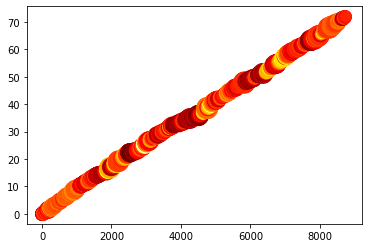

In [7]:
plt.scatter(activity["elapsed_time_s"],activity["cumulative_distance"],s=activity["power"], c=activity["speed"], cmap="hot")

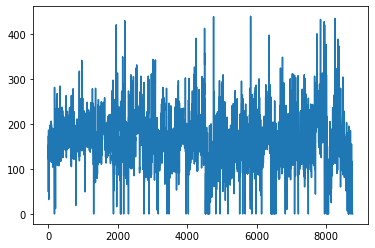

In [8]:
plt.plot(activity["elapsed_time_s"], activity["power"])

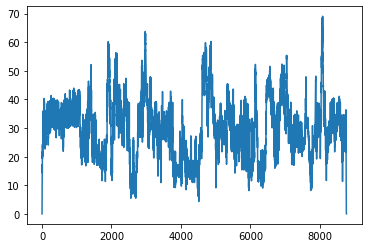

In [9]:
plt.plot(activity["elapsed_time_s"], activity["speed"])

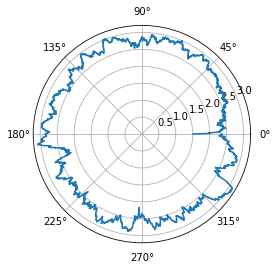

In [10]:
plt.polar(2*np.pi*activity["elapsed_time_s"]/activity["elapsed_time_s"].max(), activity["hr_resting_multiple"])


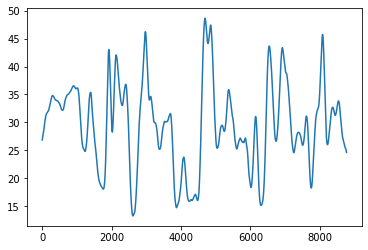

In [17]:
activity.insert(loc=0, column="smoothed99", value=utils_fx.apply_smoothing(activity, "speed", window=99, method='mean'))
plt.plot(activity["elapsed_time_s"], activity["smoothed99"])

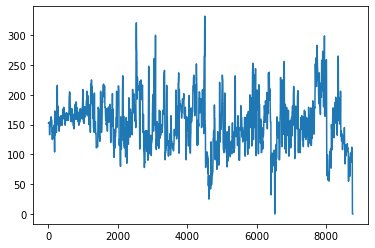

In [22]:
smoothed = utils_fx.apply_smoothing(activity=activity,key=["speed","power","hr"],window=9,method="median")
smoothed.insert(loc=0,column="elapsed_time_s",value= activity["elapsed_time_s"])
plt.plot(smoothed["elapsed_time_s"],smoothed["power"])